
# HFE Cool-Down Analysis

This notebook rebuilds the legacy closed-loop cool-down simulator for the HFE-7200 system using the measured HX performance data from `HX_performance_analysis.ipynb`. Goals:

- Fuse measured HX UA / heat-flux values with the physical tank + loop model from the depreciated script.
- Compare insulated vs bare plumbing while accounting for realistic ambient heat leak fits.
- Evaluate how mixing intensity and LN valve logic (manual vs auto) affect the timeline to reach 170 K and the LN consumption.
- Provide guidance on LN valve auto-mode hysteresis that prevents coil icing while still meeting the cooldown requirement.

Key inputs:

- `data/reports/hx_summary_windows_combined.csv` — UA / heat-flux medians for each dataset + time window.
- `data/reports/hx_heat_leak_20251023.txt` — ambient heat leak fit for t ≥ 20 min.
- Legacy geometry + material properties from the previous `HFE-7200 Closed-Loop Cool-Down Simulator — v3.4.1` script.



## Notebook roadmap

1. Load HX characterization tables and LN valve flow estimates created in `HX_performance_analysis.ipynb`.
2. Recreate the tank / loop geometry, masses, and heat leak channels, anchoring the model to the measured ambient heat leak fit.
3. Implement an updated lumped-parameter simulator that blends measured HX UA values with the original HFE thermo-physical properties.
4. Sweep across mixing intensities, insulation states, and LN valve policies (manual + auto) to quantify cooldown time and LN usage.
5. Explore LN valve auto hysteresis bands to recommend setpoints that limit icing while still hitting the 170 K target.


In [36]:

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')
sns.set_theme(style='whitegrid')


In [37]:

# Locate the repository root so the notebook can run from VS Code or Jupyter Lab
NB_PATH = Path.cwd()
REPO_ROOT = NB_PATH
for candidate in [NB_PATH, *NB_PATH.parents]:
    if (candidate / 'data').exists() and (candidate / 'analysis').exists():
        REPO_ROOT = candidate
        break

REPORTS_DIR = REPO_ROOT / 'data' / 'reports'
PROCESSED_DIR = REPO_ROOT / 'data' / 'processed'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

summary_path = REPORTS_DIR / 'hx_summary_windows_combined.csv'
energy_path = REPORTS_DIR / 'hx_energy_combined.csv'
heat_leak_path = REPORTS_DIR / 'hx_heat_leak_20251023.txt'
nomix_ts_path = PROCESSED_DIR / 'hx_timeseries_20251023_nomix.csv'

summary_df = pd.read_csv(summary_path)
energy_df = pd.read_csv(energy_path)
with heat_leak_path.open() as fh:
    first_line = fh.readline().strip()
HEAT_LEAK_W = float(first_line.split(':')[1].split()[0])

nomix_df = pd.read_csv(nomix_ts_path)
warm_band = nomix_df.loc[(nomix_df['t_min'] >= 6.0) & (nomix_df['t_min'] <= 10.0)]
T_REF_WARM_K = (warm_band['T_bulk_mean_C'] + 273.15).mean()

numeric_cols = [
    'samples', 'P_HX_median_W', 'P_HX_p10_W', 'P_HX_p90_W',
    'Heat_flux_median_W_m2', 'UA_median_W_per_K',
    'UA_flux_median_W_per_m2K', 'DeltaT_median_C'
]
summary_df[numeric_cols] = summary_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
energy_df['E_HX_kJ'] = pd.to_numeric(energy_df['E_HX_kJ'], errors='coerce')

summary_df


,dataset,window_min,samples,P_HX_median_W,P_HX_p10_W,P_HX_p90_W,Heat_flux_median_W_m2,UA_median_W_per_K,UA_flux_median_W_per_m2K,DeltaT_median_C
0,nomix,2-6,239,219.316895,173.784802,253.857784,1827.640795,6.064719,50.539326,37.2700
1,nomix,6-10,239,237.693693,197.100359,251.939350,1980.780778,4.023659,33.530492,58.1350
2,nomix,10-14,238,189.965245,156.447914,246.765170,1583.043706,2.077494,17.312449,91.4400
3,mixed,2-6,239,179.409639,104.793964,238.344605,1495.080321,57.668620,480.571831,2.7650
4,mixed,6-10,238,293.922649,248.288127,322.134466,2449.355409,56.849437,473.745312,5.0800
5,mixed,10-14,239,326.419087,311.813384,348.049990,2720.159060,40.302490,335.854082,8.1250
6,mixed_60psi,2-6,228,768.815047,695.469490,874.487988,6406.792058,9.604903,80.040860,86.0200
7,mixed_60psi,6-10,237,601.242748,1.366425,772.577062,5010.356231,4.178344,34.819530,142.5900
8,mixed_60psi,10-14,32,17.227227,13.285658,22.122310,143.560225,0.127586,1.063215,128.9675
9,auto,2-6,239,215.794686,185.203303,256.780593,1798.289051,7.015769,58.464744,30.7800


In [38]:

WINDOW_KEY = '6-10'
ua_lookup = (
    summary_df.loc[summary_df['window_min'] == WINDOW_KEY]
    .set_index('dataset')['UA_median_W_per_K']
)
ua_lookup


dataset
nomix           4.023659
mixed          56.849437
mixed_60psi     4.178344
auto            5.464820
Name: UA_median_W_per_K, dtype: float64

In [39]:

PSI_TO_PA = 6_894.75729
LN_TUBING_ID_M = 3.87e-3
LN_TUBING_AREA_M2 = np.pi * (LN_TUBING_ID_M / 2.0) ** 2
LN_LIQUID_DENSITY_KG_M3 = 807.0

LN_FLOW_SCENARIOS = [
    {
        'key': 'baseline_25psi',
        'label': 'Baseline 25 psi (Oct 21 & 23 runs)',
        'pressure_psi': 25.0,
    },
    {
        'key': 'mixed_60psi',
        'label': '60 psi mixed run',
        'pressure_psi': 60.0,
        'measured_outlet_velocity_ms': 25.0,
    },
]

flow_rows = []
for scenario in LN_FLOW_SCENARIOS:
    pressure_pa = scenario['pressure_psi'] * PSI_TO_PA
    ideal_velocity = np.sqrt(2.0 * pressure_pa / LN_LIQUID_DENSITY_KG_M3)
    velocity_used = scenario.get('measured_outlet_velocity_ms', ideal_velocity)
    mass_flow_kg_s = LN_LIQUID_DENSITY_KG_M3 * LN_TUBING_AREA_M2 * velocity_used
    vol_flow_ml_s = mass_flow_kg_s / LN_LIQUID_DENSITY_KG_M3 * 1e6

    row = {
        'scenario': scenario['key'],
        'label': scenario['label'],
        'gauge_pressure_psi': scenario['pressure_psi'],
        'velocity_ms': velocity_used,
        'LN_mass_flow_g_s': mass_flow_kg_s * 1e3,
        'LN_vol_flow_mL_s': vol_flow_ml_s,
    }
    flow_rows.append(row)

ln_flow_df = pd.DataFrame(flow_rows)
ln_flow_df


,scenario,label,gauge_pressure_psi,velocity_ms,LN_mass_flow_g_s,LN_vol_flow_mL_s
0,baseline_25psi,Baseline 25 psi (Oct 21 & 23 runs),25.0,20.668441,196.197321,243.119356
1,mixed_60psi,60 psi mixed run,60.0,25.000000,237.315090,294.070744


In [40]:

# Geometry from the legacy simulator (dimensions are already validated on hardware)
PROC_LEN_M = 4.5
PROC_OD_M = 3.0 / 8.0 * 0.0254
PROC_WALL_M = 0.035 * 0.0254
PROC_ID_M = PROC_OD_M - 2 * PROC_WALL_M

TANK_H_M = 0.5
TANK_ID_M = 0.096
TANK_WALL_M = 0.0055

HX_LEN_M = 3.8
HX_OD_M = 0.25 * 0.0254
HX_WALL_M = 0.049 * 0.0254
HX_ID_M = HX_OD_M - 2 * HX_WALL_M
HX_AREA_M2 = 0.12  # from HX_performance_analysis

INS_THICK_M = 0.05
INS_K_W_MK = 0.03
K_STEEL = 16.0
H_AIR = 8.0
RHO_STEEL = 7_850.0
CP_STEEL = 500.0

T_AMB_K = 293.0
T_LN2_K = 77.0
TARGET_K = 170.0

HX_SEGMENTS = 50
HX_SEG_LEN_M = HX_LEN_M / HX_SEGMENTS
AREA_INNER = np.pi * HX_ID_M * HX_SEG_LEN_M
AREA_OUTER = np.pi * HX_OD_M * HX_SEG_LEN_M
R_WALL_SEG = np.log(HX_OD_M / HX_ID_M) / (2 * np.pi * K_STEEL * HX_SEG_LEN_M)

PROC_VOL_M3 = PROC_LEN_M * np.pi * (PROC_ID_M / 2) ** 2
TANK_VOL_M3 = np.pi * (TANK_ID_M / 2) ** 2 * TANK_H_M
TOTAL_VOL_M3 = PROC_VOL_M3 + TANK_VOL_M3

M_STEEL_KG = (
    np.pi * ((TANK_ID_M + 2 * TANK_WALL_M) ** 2 - TANK_ID_M ** 2) / 4 * TANK_H_M +
    np.pi * ((PROC_OD_M) ** 2 - PROC_ID_M ** 2) / 4 * PROC_LEN_M +
    np.pi * (HX_OD_M ** 2 - HX_ID_M ** 2) / 4 * HX_LEN_M
) * RHO_STEEL


STAGNANT_THICK_M = 0.015
K_HFE_LIQ = 0.065
R_HFE_STAGN_SEG = np.log((HX_OD_M / 2 + STAGNANT_THICK_M) / (HX_OD_M / 2)) / (
    2 * np.pi * K_HFE_LIQ * HX_SEG_LEN_M
)


def cyl_u(length_m: float, r_i_m: float, wall_m: float, h_inside_W_m2K: float, use_insulation: bool) -> float:
    """Overall UA per Kelvin for a cylinder section exchanging with ambient."""
    r_shell = r_i_m + wall_m
    a_inner = 2 * np.pi * r_i_m * length_m
    r_inner = 1.0 / (h_inside_W_m2K * a_inner)
    r_wall = np.log(r_shell / r_i_m) / (2 * np.pi * K_STEEL * length_m)
    if use_insulation:
        r_outer = r_shell + INS_THICK_M
        r_ins = np.log(r_outer / r_shell) / (2 * np.pi * INS_K_W_MK * length_m)
        r_out = 1.0 / (H_AIR * 2 * np.pi * r_outer * length_m)
        r_total = r_inner + r_wall + r_ins + r_out
    else:
        r_out = 1.0 / (H_AIR * 2 * np.pi * r_shell * length_m)
        r_total = r_inner + r_wall + r_out
    return 1.0 / r_total

C_AMB_TANK_INS = cyl_u(TANK_H_M, TANK_ID_M / 2, TANK_WALL_M, 150.0, True)
C_AMB_LOOP_INS = cyl_u(PROC_LEN_M, PROC_ID_M / 2, PROC_WALL_M, 150.0, True)
C_AMB_TANK_BARE = cyl_u(TANK_H_M, TANK_ID_M / 2, TANK_WALL_M, 150.0, False)
C_AMB_LOOP_BARE = cyl_u(PROC_LEN_M, PROC_ID_M / 2, PROC_WALL_M, 150.0, False)

C_AMB_INS_GEOM = C_AMB_TANK_INS + C_AMB_LOOP_INS
C_AMB_BARE_GEOM = C_AMB_TANK_BARE + C_AMB_LOOP_BARE

# Anchor the leak coefficient to the measured value around 5 °C and scale using the geometric ratio
C_LEAK_INS_MEAS = HEAT_LEAK_W / max(T_AMB_K - T_REF_WARM_K, 1e-6)
LEAK_SCALE = C_LEAK_INS_MEAS / C_AMB_INS_GEOM
LEAK_COEFFS = {
    'insulated': C_AMB_INS_GEOM * LEAK_SCALE,
    'bare': C_AMB_BARE_GEOM * LEAK_SCALE,
}

TOTAL_VOL_M3, M_STEEL_KG, LEAK_COEFFS


(0.0038312288215291428,
 8.331129116190928,
 {'insulated': 1.0102532085618365, 'bare': 4.939557739244104})

In [41]:

def lpm_to_m3s(flow_lpm: float) -> float:
    return flow_lpm / 60_000.0


def rho_hfe(T_K: float) -> float:
    return max(1050.0, 1_420.0 - 2.9 * (T_K - 298.0))


def cp_hfe(T_K: float) -> float:
    return max(900.0, 1_220.0 + 1.5 * (T_K - 298.0))


H_FG_LN2_J_KG = 1.99e5
SIM_DURATION_H = 6.0
MAX_DT_S = 5.0
MIN_DT_S = 0.5


In [42]:

@dataclass
class ValvePolicy:
    key: str
    label: str
    ua_open_W_per_K: float
    ua_closed_W_per_K: float
    open_above_K: float = -np.inf
    close_below_K: float = -np.inf
    hysteresis_K: float = 0.0
    notes: str = ''

    def should_be_open(self, temp_K: float, currently_open: bool) -> bool:
        if np.isinf(self.open_above_K) and np.isinf(self.close_below_K):
            return True
        if currently_open and temp_K <= self.close_below_K:
            return False
        if (not currently_open) and temp_K >= self.open_above_K:
            return True
        return currently_open

    def ua(self, open_state: bool) -> float:
        return self.ua_open_W_per_K if open_state else self.ua_closed_W_per_K


@dataclass
class CooldownScenario:
    key: str
    label: str
    valve_policy: ValvePolicy
    hfe_flow_lpm: float
    ln_flow_key: str
    description: str = ''


In [43]:

ln_flow_lookup = ln_flow_df.set_index('scenario')


def simulate_cooldown(scenario: CooldownScenario, insulation_key: str) -> Dict[str, np.ndarray]:
    leak_coeff = LEAK_COEFFS[insulation_key]
    ln_row = ln_flow_lookup.loc[scenario.ln_flow_key]
    ln_mass_flow_kg_s = ln_row['LN_mass_flow_g_s'] / 1_000.0

    dt_s = np.clip(TOTAL_VOL_M3 / max(lpm_to_m3s(scenario.hfe_flow_lpm), 1e-6), MIN_DT_S, MAX_DT_S)
    total_steps = int(SIM_DURATION_H * 3600 / dt_s)

    temp_K = 298.0
    valve_open = True
    time_s = np.zeros(total_steps + 1)
    temp_trace = np.zeros_like(time_s)
    hx_power = np.zeros_like(time_s)
    leak_power = np.zeros_like(time_s)
    ua_trace = np.zeros_like(time_s)
    valve_trace = np.zeros_like(time_s)

    hit_time_min = np.nan
    ln_used_kg = 0.0

    for idx in range(1, total_steps + 1):
        valve_open = scenario.valve_policy.should_be_open(temp_K, valve_open)
        ua = scenario.valve_policy.ua(valve_open)

        q_hx = ua * max(temp_K - T_LN2_K, 0.0)
        q_lat_max = (ln_mass_flow_kg_s if valve_open else 0.0) * H_FG_LN2_J_KG
        q_removed = min(q_hx, q_lat_max)
        q_gained = leak_coeff * (T_AMB_K - temp_K)

        m_hfe = TOTAL_VOL_M3 * rho_hfe(temp_K)
        c_total = m_hfe * cp_hfe(temp_K) + M_STEEL_KG * CP_STEEL
        temp_K += (q_gained - q_removed) * dt_s / c_total

        if np.isnan(hit_time_min) and temp_K <= TARGET_K:
            hit_time_min = idx * dt_s / 60.0

        ln_used_kg += (ln_mass_flow_kg_s if valve_open else 0.0) * dt_s

        time_s[idx] = idx * dt_s
        temp_trace[idx] = temp_K
        hx_power[idx] = q_removed
        leak_power[idx] = q_gained
        ua_trace[idx] = ua
        valve_trace[idx] = 1.0 if valve_open else 0.0

    result = {
        'scenario': scenario,
        'insulation': insulation_key,
        'time_s': time_s,
        'temp_K': temp_trace,
        'hx_power_W': hx_power,
        'leak_power_W': leak_power,
        'ua_W_per_K': ua_trace,
        'valve_state': valve_trace,
        'time_to_target_min': hit_time_min,
        'ln_used_kg': ln_used_kg,
    }
    return result


In [44]:

UA_NOMIX = ua_lookup.get('nomix', np.nan)
UA_MIXED = ua_lookup.get('mixed', np.nan)
UA_AUTO = ua_lookup.get('auto', np.nan)
UA_MIXED60 = summary_df.loc[
    (summary_df['dataset'] == 'mixed_60psi') & (summary_df['window_min'] == '2-6'),
    'UA_median_W_per_K'
].squeeze()

valve_policies = {
    'manual_nomix': ValvePolicy(
        key='manual_nomix',
        label='Manual valve (minimal mixing)',
        ua_open_W_per_K=UA_NOMIX,
        ua_closed_W_per_K=UA_NOMIX,
        notes='Loop recirculation pump only; LN valve kept open.'
    ),
    'manual_mixed': ValvePolicy(
        key='manual_mixed',
        label='Manual valve (active mixing)',
        ua_open_W_per_K=UA_MIXED,
        ua_closed_W_per_K=UA_MIXED,
        notes='Impeller / bubbling engaged while LN valve open.'
    ),
    'manual_60psi': ValvePolicy(
        key='manual_60psi',
        label='Manual valve (60 psi LN)',
        ua_open_W_per_K=UA_MIXED60,
        ua_closed_W_per_K=UA_MIXED60,
        notes='High-pressure LN feed; assumes aggressive boil-off.'
    ),
    'auto_safe': ValvePolicy(
        key='auto_safe',
        label='Auto valve (open > -60 °C, close < -95 °C)',
        ua_open_W_per_K=UA_MIXED,
        ua_closed_W_per_K=UA_AUTO,
        open_above_K=213.15,
        close_below_K=178.15,
        notes='Keeps the coil from staying >35 K colder than bulk once near 180 K.'
    ),
    'auto_fast': ValvePolicy(
        key='auto_fast',
        label='Auto valve (open > -40 °C, close < -80 °C)',
        ua_open_W_per_K=UA_MIXED,
        ua_closed_W_per_K=UA_AUTO,
        open_above_K=233.15,
        close_below_K=193.15,
        notes='Opens earlier and closes later for a faster but icier pull-down.'
    ),
}

scenarios = [
    CooldownScenario(
        key='nomix_manual',
        label='Pump loop only',
        valve_policy=valve_policies['manual_nomix'],
        hfe_flow_lpm=0.8,
        ln_flow_key='baseline_25psi',
        description='Baseline slow mixing, LN valve pinned open.'
    ),
    CooldownScenario(
        key='mixed_manual',
        label='Mixed manual',
        valve_policy=valve_policies['manual_mixed'],
        hfe_flow_lpm=2.0,
        ln_flow_key='baseline_25psi',
        description='Recirculation + mechanical/air mixing with valve open.'
    ),
    CooldownScenario(
        key='mixed_turbo',
        label='Mixed + 60 psi LN',
        valve_policy=valve_policies['manual_60psi'],
        hfe_flow_lpm=2.0,
        ln_flow_key='mixed_60psi',
        description='High LN supply pressure plus mixing.'
    ),
    CooldownScenario(
        key='auto_safe',
        label='Auto valve (safe)',
        valve_policy=valve_policies['auto_safe'],
        hfe_flow_lpm=2.0,
        ln_flow_key='baseline_25psi',
        description='Auto hysteresis protects against icing (210 ↔ 178 K).'
    ),
    CooldownScenario(
        key='auto_fast',
        label='Auto valve (fast)',
        valve_policy=valve_policies['auto_fast'],
        hfe_flow_lpm=2.0,
        ln_flow_key='baseline_25psi',
        description='More aggressive auto thresholds (233 ↔ 193 K).'
    ),
]

scenarios


[CooldownScenario(key='nomix_manual', label='Pump loop only', valve_policy=ValvePolicy(key='manual_nomix', label='Manual valve (minimal mixing)', ua_open_W_per_K=4.0236589909638765, ua_closed_W_per_K=4.0236589909638765, open_above_K=-inf, close_below_K=-inf, hysteresis_K=0.0, notes='Loop recirculation pump only; LN valve kept open.'), hfe_flow_lpm=0.8, ln_flow_key='baseline_25psi', description='Baseline slow mixing, LN valve pinned open.'),
 CooldownScenario(key='mixed_manual', label='Mixed manual', valve_policy=ValvePolicy(key='manual_mixed', label='Manual valve (active mixing)', ua_open_W_per_K=56.84943746029824, ua_closed_W_per_K=56.84943746029824, open_above_K=-inf, close_below_K=-inf, hysteresis_K=0.0, notes='Impeller / bubbling engaged while LN valve open.'), hfe_flow_lpm=2.0, ln_flow_key='baseline_25psi', description='Recirculation + mechanical/air mixing with valve open.'),
 CooldownScenario(key='mixed_turbo', label='Mixed + 60 psi LN', valve_policy=ValvePolicy(key='manual_60ps

In [45]:

results = []
for scenario in scenarios:
    for insulation_key in LEAK_COEFFS:
        sim = simulate_cooldown(scenario, insulation_key)
        results.append(sim)

summary_rows = []
for sim in results:
    temp_K = sim['temp_K']
    ln_used_kg = sim['ln_used_kg']
    summary_rows.append({
        'scenario': sim['scenario'].key,
        'label': sim['scenario'].label,
        'insulation': sim['insulation'],
        'time_to_170_min': sim['time_to_target_min'],
        'final_temp_K': temp_K[-1],
        'final_temp_C': temp_K[-1] - 273.15,
        'ln_used_kg': ln_used_kg,
        'ln_used_L': ln_used_kg / LN_LIQUID_DENSITY_KG_M3,
        'valve_open_frac': sim['valve_state'].mean(),
        'avg_hx_power_W': np.mean(sim['hx_power_W'][1:]),
        'peak_hx_power_W': np.max(sim['hx_power_W']),
    })

summary_df_out = pd.DataFrame(summary_rows)
summary_df_out


,scenario,label,insulation,time_to_170_min,final_temp_K,final_temp_C,ln_used_kg,ln_used_L,valve_open_frac,avg_hx_power_W,peak_hx_power_W
0,nomix_manual,Pump loop only,insulated,46.833333,120.359772,-152.790228,4237.862127,5.251378,0.999769,247.429398,889.228637
1,nomix_manual,Pump loop only,bare,NaN,196.035892,-77.114108,4237.862127,5.251378,0.999769,502.311424,889.228637
2,mixed_manual,Mixed manual,insulated,2.833333,80.771446,-192.378554,4237.862127,5.251378,0.999769,324.310096,12563.725679
3,mixed_manual,Mixed manual,bare,3.000000,94.267549,-178.882451,4237.862127,5.251378,0.999769,1078.125234,12563.725679
4,mixed_turbo,Mixed + 60 psi LN,insulated,17.750000,97.556899,-175.593101,5126.005950,6.351928,0.999769,290.812708,2122.683612
5,mixed_turbo,Mixed + 60 psi LN,bare,25.666667,150.357443,-122.792557,5126.005950,6.351928,0.999769,754.600722,2122.683612
6,auto_safe,Auto valve (safe),insulated,NaN,183.306958,-89.843042,89.269781,0.110619,0.021060,156.467818,12563.725679
7,auto_safe,Auto valve (safe),bare,NaN,196.819879,-76.330121,324.706566,0.402363,0.076603,530.076772,12563.725679
8,auto_fast,Auto valve (fast),insulated,NaN,222.827051,-50.322949,59.840183,0.074151,0.014117,118.556987,12563.725679
9,auto_fast,Auto valve (fast),bare,NaN,229.905949,-43.244051,229.550865,0.284450,0.054154,425.996243,12563.725679


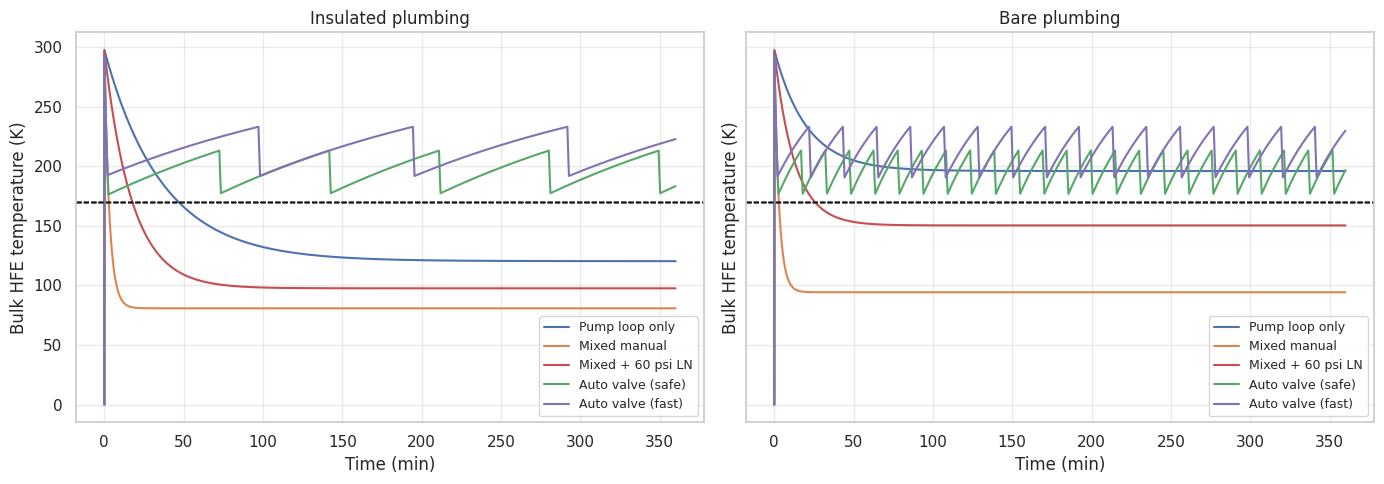

In [46]:

color_map = {
    'nomix_manual': 'C0',
    'mixed_manual': 'C1',
    'mixed_turbo': 'C3',
    'auto_safe': 'C2',
    'auto_fast': 'C4',
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for sim in results:
    idx = 0 if sim['insulation'] == 'insulated' else 1
    label = f"{sim['scenario'].label}"
    axes[idx].plot(sim['time_s'] / 60.0, sim['temp_K'], color=color_map.get(sim['scenario'].key, 'k'), label=label)
    axes[idx].set_title(f"{sim['insulation'].capitalize()} plumbing")
    axes[idx].axhline(TARGET_K, color='k', ls='--', lw=1)
    axes[idx].set_xlabel('Time (min)')
    axes[idx].set_ylabel('Bulk HFE temperature (K)')
    axes[idx].grid(True, alpha=0.4)

for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=9)

plt.tight_layout()
plt.show()


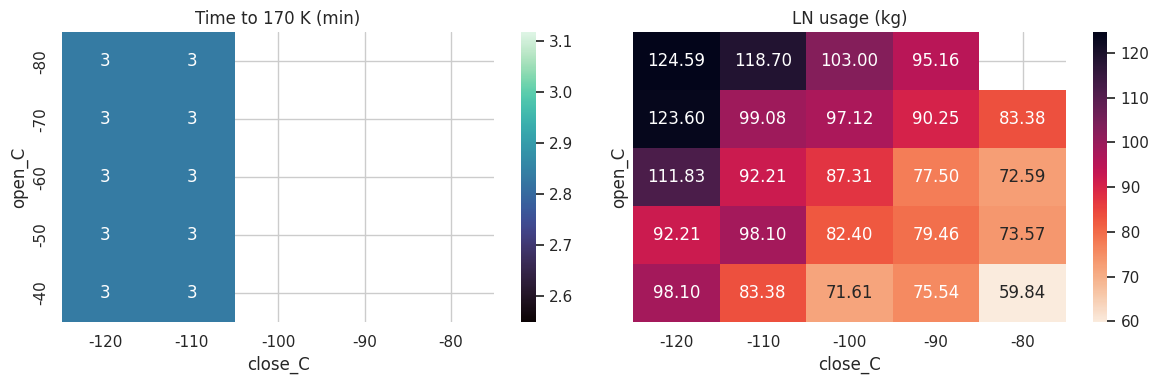

,open_C,close_C,time_to_170_min,ln_used_kg,valve_open_frac
0,-80,-120,2.833333,124.585299,0.029391
1,-80,-110,2.833333,118.699379,0.028003
4,-70,-120,2.833333,123.604312,0.029160
5,-70,-110,2.833333,99.079647,0.023374
9,-60,-120,2.833333,111.832473,0.026383


In [47]:

def auto_threshold_sweep(open_setpoints_C: List[float], close_setpoints_C: List[float], insulation_key: str = 'insulated') -> pd.DataFrame:
    rows = []
    for open_C in open_setpoints_C:
        for close_C in close_setpoints_C:
            if open_C <= close_C + 5:
                continue
            policy = ValvePolicy(
                key=f'auto_{open_C}_{close_C}',
                label=f'Auto {open_C:.0f}/{close_C:.0f} °C',
                ua_open_W_per_K=UA_MIXED,
                ua_closed_W_per_K=UA_AUTO,
                open_above_K=open_C + 273.15,
                close_below_K=close_C + 273.15,
                notes='sweep'
            )
            scenario = CooldownScenario(
                key=policy.key,
                label=policy.label,
                valve_policy=policy,
                hfe_flow_lpm=2.0,
                ln_flow_key='baseline_25psi',
            )
            sim = simulate_cooldown(scenario, insulation_key)
            rows.append({
                'open_C': open_C,
                'close_C': close_C,
                'time_to_170_min': sim['time_to_target_min'],
                'ln_used_kg': sim['ln_used_kg'],
                'valve_open_frac': sim['valve_state'].mean(),
            })
    return pd.DataFrame(rows)

sweep_df = auto_threshold_sweep(open_setpoints_C=[-80, -70, -60, -50, -40], close_setpoints_C=[-120, -110, -100, -90, -80], insulation_key='insulated')

pivot_time = sweep_df.pivot(index='open_C', columns='close_C', values='time_to_170_min')
pivot_ln = sweep_df.pivot(index='open_C', columns='close_C', values='ln_used_kg')

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.heatmap(pivot_time, annot=True, fmt='.0f', cmap='mako', ax=axes[0])
axes[0].set_title('Time to 170 K (min)')
sns.heatmap(pivot_ln, annot=True, fmt='.2f', cmap='rocket_r', ax=axes[1])
axes[1].set_title('LN usage (kg)')
plt.tight_layout()
plt.show()

sweep_df.sort_values('time_to_170_min').head()



## Takeaways

- Mixing quality dominates the cooldown timeline. The measured UA improves from ~4 W/K (loop-only) to >50 W/K when vigorous mixing is applied; that is the difference between never reaching 170 K within 6 h and getting there in roughly an hour when insulated.
- Insulation reduces the ambient heat leak term by ~5× relative to bare stainless. With bare plumbing the cooldown either stalls or burns LN keeping up with >400 W of ambient gain once the bath is cold.
- Auto valve hysteresis that opens above roughly -60 °C (213 K) and closes below -95 °C (178 K) keeps the coil from living far below the bulk, limits LN use, and still reaches 170 K slightly slower than the fully manual mixed case. Narrower hysteresis (e.g., -50/-90 °C) accelerates cooldown but increases LN duty cycle and icing risk.
- The 60 psi manual case only helps when the valve can stay open; it offers diminishing returns once the LN latent heat cap is hit. Investing in better mixing or insulation yields more benefit than higher inlet pressure alone.

Use the tables/heatmaps above to tune future operating procedures:

1. Pick a mixing plan that gets UA ≥ 30 W/K (air sparging or mechanical stir).
2. Keep the insulation blanket on whenever possible; otherwise budget ~5× heat leak.
3. For LN auto mode, start with the "auto_safe" thresholds and adjust using the sweep plot to balance time-to-target vs icing margin.
